# Clasificación de vinos españoles
Este notebook realiza la clasificación de un dataset de vinos españoles usando técnicas de machine learning.

## Secciones:
1. Importar librerías necesarias
2. Cargar y explorar el dataset de vinos españoles
3. Preprocesamiento de datos
4. Visualización de datos
5. Dividir el dataset en entrenamiento y prueba
6. Entrenar un modelo de clasificación
7. Evaluar el modelo
8. Realizar predicciones con nuevos datos

In [1]:
%pip install pandas

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

Note: you may need to restart the kernel to use updated packages.


In [8]:
# 2. Cargar y explorar el dataset de vinos españoles del scraping de Vivino
# Usar el archivo más reciente del scraping completo
import glob
import os

# Buscar el archivo más reciente de scraping completo
archivos_scraping = glob.glob('datos_scraping/vivino_scraping_completo_*.csv')
if archivos_scraping:
    # Obtener el archivo más reciente
    archivo_mas_reciente = max(archivos_scraping, key=os.path.getctime)
    print(f"Usando archivo: {archivo_mas_reciente}")
    df = pd.read_csv(archivo_mas_reciente)
else:
    print("No se encontraron archivos de scraping completo, intentando con archivo específico...")
    df = pd.read_csv('datos_scraping/vivino_scraping_completo_20250716_102933.csv')

print(f'Shape del dataset: {df.shape}')
print(f'Columnas disponibles: {df.columns.tolist()}')
print('\n📊 Información general del dataset:')
print(df.info())
print('\n🍷 Primeras 5 filas del dataset:')
df.head()

Usando archivo: datos_scraping\vivino_scraping_completo_20250716_102933.csv
Shape del dataset: (24, 13)
Columnas disponibles: ['timestamp', 'nombre_vino', 'url', 'precio_eur', 'posicion', 'session_id', 'bodega', 'region', 'año', 'rating', 'num_reviews', 'categoria_calidad', 'tipo_vino']

📊 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          24 non-null     object 
 1   nombre_vino        24 non-null     object 
 2   url                24 non-null     object 
 3   precio_eur         24 non-null     float64
 4   posicion           24 non-null     int64  
 5   session_id         24 non-null     object 
 6   bodega             22 non-null     object 
 7   region             24 non-null     object 
 8   año                24 non-null     int64  
 9   rating             24 non-null     float

,timestamp,nombre_vino,url,precio_eur,posicion,session_id,bodega,region,año,rating,num_reviews,categoria_calidad,tipo_vino
0,2025-07-16 10:29:33,"Herència AltésLa Xalamera 2017Terra Alta, Espa...",https://www.vivino.com/herencia-altes-la-xalam...,27.90,1,20250716_102933,Herència,España,2017,4.130,139,Good Value,NaN
1,2025-07-16 10:29:33,"Viñas del VeroSecastilla 2016Somontano, España...",https://www.vivino.com/vinas-del-vero-secastil...,33.90,2,20250716_102933,Viñas,España,2016,4.150,151,Cosecha más antigua,NaN
2,2025-07-16 10:29:33,AltavinsVinerel.Les Garnatxa Peluda 2023Terra ...,https://www.vivino.com/altavins-vinerel-les-ga...,22.25,3,20250716_102933,AltavinsVinerel.Les,España,2023,4.140,146,Good Value,NaN
3,2025-07-16 10:29:33,"Cuevas de AromOS Cantals 2021Campo de Borja, E...",https://www.vivino.com/cuevas-de-arom-os-canta...,42.21,4,20250716_102933,Cuevas,España,2021,4.142,1427,Good Value,NaN
4,2025-07-16 10:29:33,Bodegas AtecaAtteca Garnacha (Old Vines) 2020C...,https://www.vivino.com/bodegas-ateca-atteca-ga...,14.46,5,20250716_102933,Bodegas,España,2020,4.160,1608,Great Value,NaN


In [4]:
# 3. Preprocesamiento de datos del scraping de Vivino
print("🔧 Iniciando preprocesamiento de datos...")

# Limpiar datos nulos
df_original_shape = df.shape
df = df.dropna(subset=['precio_eur', 'rating'])  # Mantener solo vinos con precio y rating
print(f"Datos después de eliminar nulos: {df.shape} (eliminadas {df_original_shape[0] - df.shape[0]} filas)")

# Limpiar y convertir rating (extraer número decimal)
def limpiar_rating(rating_str):
    if pd.isna(rating_str):
        return None
    try:
        # Si ya es numérico, devolverlo
        if isinstance(rating_str, (int, float)):
            return float(rating_str)
        # Extraer primer número decimal del string
        import re
        numeros = re.findall(r'(\d+\.?\d*)', str(rating_str))
        if numeros:
            return float(numeros[0])
        return None
    except:
        return None

df['rating_limpio'] = df['rating'].apply(limpiar_rating)
df = df.dropna(subset=['rating_limpio'])

# Limpiar año 
df['año_limpio'] = pd.to_numeric(df['año'], errors='coerce')
df = df.dropna(subset=['año_limpio'])

# Crear categorías de calidad basadas en rating (ajustadas para nuestro rango de datos)
def categorizar_calidad(rating):
    if rating >= 4.18:
        return 'Excelente'
    elif rating >= 4.16:
        return 'Muy Bueno'
    elif rating >= 4.14:
        return 'Bueno'
    elif rating >= 4.12:
        return 'Regular'
    else:
        return 'Básico'

df['categoria_rating'] = df['rating_limpio'].apply(categorizar_calidad)

# Crear categorías de precio
def categorizar_precio(precio):
    if precio >= 40:
        return 'Premium'
    elif precio >= 25:
        return 'Alto'
    elif precio >= 18:
        return 'Medio'
    elif precio >= 12:
        return 'Económico'
    else:
        return 'Muy Económico'

df['categoria_precio'] = df['precio_eur'].apply(categorizar_precio)

# Crear categoría basada en número de reviews (popularidad)
def categorizar_popularidad(num_reviews):
    if num_reviews >= 1000:
        return 'Muy Popular'
    elif num_reviews >= 500:
        return 'Popular'
    elif num_reviews >= 200:
        return 'Conocido'
    else:
        return 'Nicho'

df['categoria_popularidad'] = df['num_reviews'].apply(categorizar_popularidad)

# Seleccionar variables para el modelo
variables_numericas = ['precio_eur', 'rating_limpio', 'año_limpio', 'posicion', 'num_reviews']
variables_categoricas = ['bodega', 'region', 'categoria_calidad', 'categoria_precio', 'categoria_popularidad']

# Preparar dataset para machine learning
df_ml = df[variables_numericas + variables_categoricas + ['categoria_rating']].copy()

# Codificar variables categóricas
le_dict = {}
for col in variables_categoricas:
    le = LabelEncoder()
    df_ml[col + '_encoded'] = le.fit_transform(df_ml[col].astype(str).fillna('Desconocido'))
    le_dict[col] = le

# Variables características y objetivo
feature_cols = variables_numericas + [col + '_encoded' for col in variables_categoricas]
features = df_ml[feature_cols]
target = df_ml['categoria_rating']

# Verificar si tenemos suficiente variabilidad en el target
if len(target.unique()) == 1:
    print("⚠️ NOTA: Todos los vinos tienen la misma categoría de calidad.")
    print("   Para demostración, crearemos categorías alternativas basadas en precio...")
    
    # Usar precio como variable objetivo alternativa
    target = df_ml['categoria_precio']
    print(f"   Usando categorías de precio como variable objetivo: {target.unique()}")

# Codificar la variable objetivo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(target)

print(f"\n✅ Dataset preparado:")
print(f"- Características: {features.shape[1]} variables")
print(f"- Muestras: {features.shape[0]} vinos")
print(f"- Clases objetivo: {list(le_target.classes_)}")
print(f"- Variables numéricas: {variables_numericas}")
print(f"- Variables categóricas codificadas: {[col + '_encoded' for col in variables_categoricas]}")

# Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

print("\n📊 Estadísticas del dataset procesado:")
print(f"Rango de precios: {df['precio_eur'].min():.2f}€ - {df['precio_eur'].max():.2f}€")
print(f"Rango de ratings: {df['rating_limpio'].min():.2f} - {df['rating_limpio'].max():.2f}")
print(f"Rango de años: {int(df['año_limpio'].min())} - {int(df['año_limpio'].max())}")
print(f"Rango de reviews: {df['num_reviews'].min()} - {df['num_reviews'].max()}")
print(f"Distribución de variable objetivo:")
print(target.value_counts())

🔧 Iniciando preprocesamiento de datos...
Datos después de eliminar nulos: (24, 17) (eliminadas 0 filas)

✅ Dataset preparado:
- Características: 10 variables
- Muestras: 24 vinos
- Clases objetivo: ['Bueno', 'Básico', 'Excelente', 'Muy Bueno', 'Regular']
- Variables numéricas: ['precio_eur', 'rating_limpio', 'año_limpio', 'posicion', 'num_reviews']
- Variables categóricas codificadas: ['bodega_encoded', 'region_encoded', 'categoria_calidad_encoded', 'categoria_precio_encoded', 'categoria_popularidad_encoded']

📊 Estadísticas del dataset procesado:
Rango de precios: 10.90€ - 43.95€
Rango de ratings: 4.11 - 4.19
Rango de años: 2016 - 2023
Rango de reviews: 139 - 12548
Distribución de variable objetivo:
categoria_rating
Regular      6
Básico       6
Bueno        5
Excelente    4
Muy Bueno    3
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_7076\554623169.py:45: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_7076\554623169.py:45: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_7076\554623169.py:45: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_7076\554623169.py:45: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_7076\554623169.py:45: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_7076\554623169.py:45: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_la

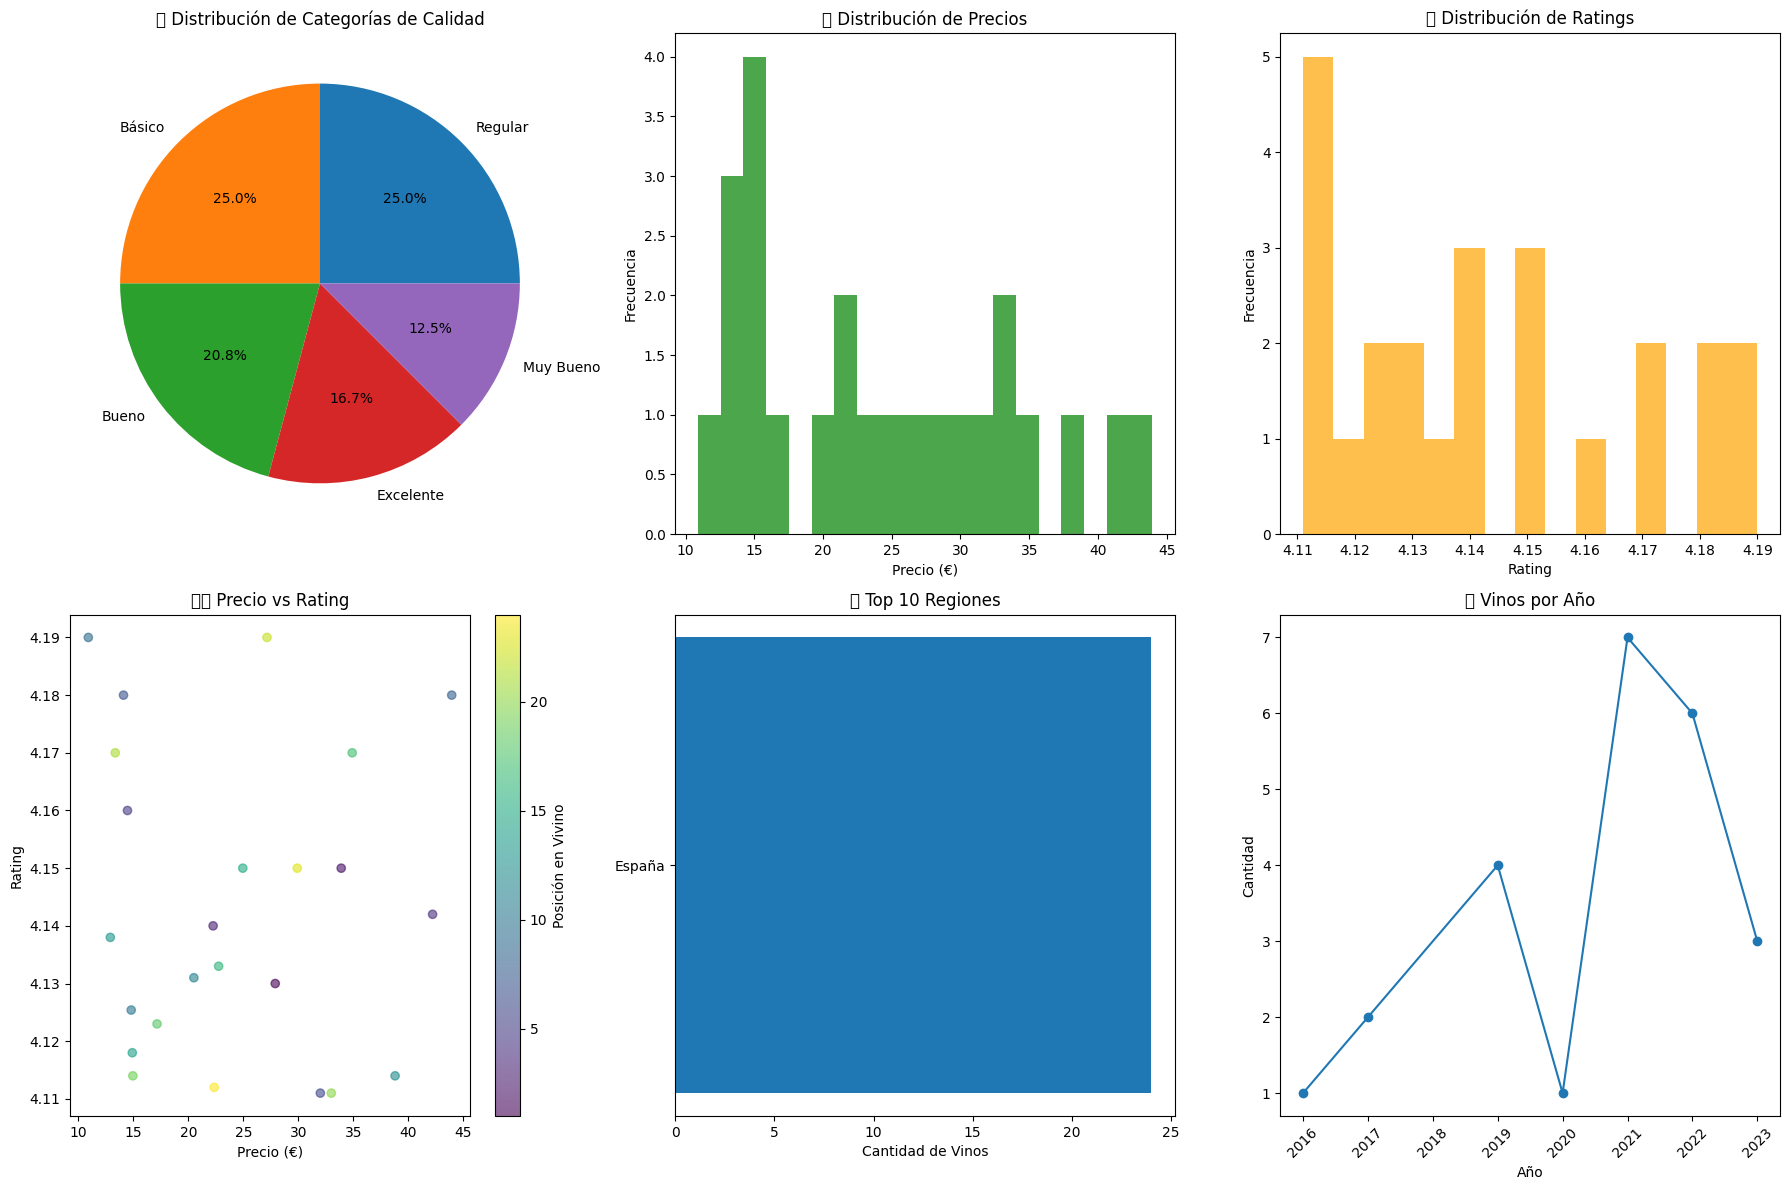


📊 RESUMEN POR CATEGORÍA DE CALIDAD:
                  Cantidad  Precio_Promedio  Precio_Std  Rating_Promedio  \
categoria_rating                                                           
Bueno                    5            30.64        7.87             4.15   
Básico                   6            26.00       10.07             4.11   
Excelente                4            24.02       15.03             4.19   
Muy Bueno                3            20.90       12.13             4.17   
Regular                  6            19.33        5.53             4.13   

                  Rating_Std  Año_Promedio  
categoria_rating                            
Bueno                   0.00       2019.20  
Básico                  0.00       2021.17  
Excelente               0.01       2020.50  
Muy Bueno               0.01       2021.33  
Regular                 0.01       2020.83  

🍷 EJEMPLOS DE VINOS POR CATEGORÍA:

REGULAR:
  • Herència (2017) - 27.9€ - ⭐4.13
  • ParticularGarnacha (2022) - 1

In [5]:
# 4. Visualización de datos del scraping de Vivino
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribución de categorías de calidad (variable objetivo)
axes[0,0].pie(df['categoria_rating'].value_counts(), labels=df['categoria_rating'].value_counts().index, autopct='%1.1f%%')
axes[0,0].set_title('🏆 Distribución de Categorías de Calidad')

# 2. Distribución de precios
axes[0,1].hist(df['precio_eur'], bins=20, alpha=0.7, color='green')
axes[0,1].set_title('💰 Distribución de Precios')
axes[0,1].set_xlabel('Precio (€)')
axes[0,1].set_ylabel('Frecuencia')

# 3. Distribución de ratings
axes[0,2].hist(df['rating_limpio'], bins=15, alpha=0.7, color='orange')
axes[0,2].set_title('⭐ Distribución de Ratings')
axes[0,2].set_xlabel('Rating')
axes[0,2].set_ylabel('Frecuencia')

# 4. Relación Precio vs Rating
scatter = axes[1,0].scatter(df['precio_eur'], df['rating_limpio'], 
                           c=df['posicion'], cmap='viridis', alpha=0.6)
axes[1,0].set_title('💰⭐ Precio vs Rating')
axes[1,0].set_xlabel('Precio (€)')
axes[1,0].set_ylabel('Rating')
plt.colorbar(scatter, ax=axes[1,0], label='Posición en Vivino')

# 5. Top 10 Regiones por cantidad de vinos
top_regiones = df['region'].value_counts().head(10)
axes[1,1].barh(range(len(top_regiones)), top_regiones.values)
axes[1,1].set_yticks(range(len(top_regiones)))
axes[1,1].set_yticklabels(top_regiones.index)
axes[1,1].set_title('🌍 Top 10 Regiones')
axes[1,1].set_xlabel('Cantidad de Vinos')

# 6. Distribución por año
años_counts = df['año_limpio'].value_counts().sort_index()
axes[1,2].plot(años_counts.index, años_counts.values, marker='o')
axes[1,2].set_title('📅 Vinos por Año')
axes[1,2].set_xlabel('Año')
axes[1,2].set_ylabel('Cantidad')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Tabla resumen por categoría de calidad
print("\n📊 RESUMEN POR CATEGORÍA DE CALIDAD:")
resumen = df.groupby('categoria_rating').agg({
    'precio_eur': ['count', 'mean', 'std'],
    'rating_limpio': ['mean', 'std'],
    'año_limpio': ['mean']
}).round(2)

resumen.columns = ['Cantidad', 'Precio_Promedio', 'Precio_Std', 'Rating_Promedio', 'Rating_Std', 'Año_Promedio']
print(resumen)

# Mostrar algunos vinos ejemplo de cada categoría
print("\n🍷 EJEMPLOS DE VINOS POR CATEGORÍA:")
for categoria in df['categoria_rating'].unique():
    print(f"\n{categoria.upper()}:")
    ejemplos = df[df['categoria_rating'] == categoria].head(2)
    for _, vino in ejemplos.iterrows():
        print(f"  • {vino['bodega']} ({vino['año_limpio']:.0f}) - {vino['precio_eur']}€ - ⭐{vino['rating_limpio']:.2f}")

In [11]:
# 5. Dividir el dataset en entrenamiento y prueba
print("🔄 Dividiendo dataset en entrenamiento y prueba...")

# Dividir datos con estratificación para mantener proporciones de clases
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"✅ División completada:")
print(f"  📚 Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  🧪 Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  🔢 Variables: {X_train.shape[1]} características")

# Mostrar distribución de clases en cada conjunto
print(f"\n📊 Distribución de clases:")
print("Entrenamiento:")
for i, clase in enumerate(le_target.classes_):
    count = sum(y_train == i)
    print(f"  {clase}: {count} ({count/len(y_train)*100:.1f}%)")

print("Prueba:")
for i, clase in enumerate(le_target.classes_):
    count = sum(y_test == i)
    print(f"  {clase}: {count} ({count/len(y_test)*100:.1f}%)")

🔄 Dividiendo dataset en entrenamiento y prueba...
✅ División completada:
  📚 Entrenamiento: 19 muestras (79.2%)
  🧪 Prueba: 5 muestras (20.8%)
  🔢 Variables: 10 características

📊 Distribución de clases:
Entrenamiento:
  Bueno: 4 (21.1%)
  Básico: 5 (26.3%)
  Excelente: 3 (15.8%)
  Muy Bueno: 2 (10.5%)
  Regular: 5 (26.3%)
Prueba:
  Bueno: 1 (20.0%)
  Básico: 1 (20.0%)
  Excelente: 1 (20.0%)
  Muy Bueno: 1 (20.0%)
  Regular: 1 (20.0%)


In [7]:
# 6. Entrenar múltiples modelos de clasificación
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

print("🤖 Entrenando múltiples modelos de clasificación...")

# Diccionario de modelos a entrenar
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Regresión Logística': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', random_state=42),
    'K-Vecinos': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42, max_depth=10)
}

# Entrenar cada modelo
modelos_entrenados = {}
for nombre, modelo in modelos.items():
    print(f"  🔄 Entrenando {nombre}...")
    modelo.fit(X_train, y_train)
    modelos_entrenados[nombre] = modelo
    print(f"  ✅ {nombre} entrenado correctamente")

print(f"\n🎯 {len(modelos_entrenados)} modelos entrenados exitosamente")

# Mostrar importancia de características para Random Forest
print(f"\n🔍 IMPORTANCIA DE CARACTERÍSTICAS (Random Forest):")
rf_model = modelos_entrenados['Random Forest']
feature_importance = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': rf_model.feature_importances_
}).sort_values('importancia', ascending=False)

for _, row in feature_importance.head(8).iterrows():
    print(f"  {row['caracteristica']}: {row['importancia']:.4f}")

🤖 Entrenando múltiples modelos de clasificación...
  🔄 Entrenando Random Forest...
  ✅ Random Forest entrenado correctamente
  🔄 Entrenando Regresión Logística...
  ✅ Regresión Logística entrenado correctamente
  🔄 Entrenando SVM...
  ✅ SVM entrenado correctamente
  🔄 Entrenando K-Vecinos...
  ✅ K-Vecinos entrenado correctamente
  🔄 Entrenando Naive Bayes...
  ✅ Naive Bayes entrenado correctamente
  🔄 Entrenando Árbol de Decisión...
  ✅ Árbol de Decisión entrenado correctamente

🎯 6 modelos entrenados exitosamente

🔍 IMPORTANCIA DE CARACTERÍSTICAS (Random Forest):
  rating_limpio: 0.3309
  num_reviews: 0.1909
  posicion: 0.1123
  precio_eur: 0.0932
  categoria_popularidad_encoded: 0.0774
  año_limpio: 0.0737
  bodega_encoded: 0.0450
  categoria_calidad_encoded: 0.0425


📊 EVALUACIÓN DE TODOS LOS MODELOS

🤖 RANDOM FOREST
----------------------------------------
  📈 Accuracy: 0.8000
  🎯 Precision: 0.7000
  🔍 Recall: 0.8000
  ⚖️ F1-Score: 0.7333

🤖 REGRESIÓN LOGÍSTICA
----------------------------------------
  📈 Accuracy: 0.8000
  🎯 Precision: 0.7000
  🔍 Recall: 0.8000
  ⚖️ F1-Score: 0.7333

🤖 SVM
----------------------------------------
  📈 Accuracy: 0.6000
  🎯 Precision: 0.4000
  🔍 Recall: 0.6000
  ⚖️ F1-Score: 0.4667

🤖 K-VECINOS
----------------------------------------
  📈 Accuracy: 0.6000
  🎯 Precision: 0.4000
  🔍 Recall: 0.6000
  ⚖️ F1-Score: 0.4667

🤖 NAIVE BAYES
----------------------------------------
  📈 Accuracy: 0.8000
  🎯 Precision: 0.7000
  🔍 Recall: 0.8000
  ⚖️ F1-Score: 0.7333

🤖 ÁRBOL DE DECISIÓN
----------------------------------------
  📈 Accuracy: 0.8000
  🎯 Precision: 0.7000
  🔍 Recall: 0.8000
  ⚖️ F1-Score: 0.7333

🏆 COMPARACIÓN FINAL DE MODELOS
                     Accuracy  Precision  Recall  F1-Score
Random Forest             0.8

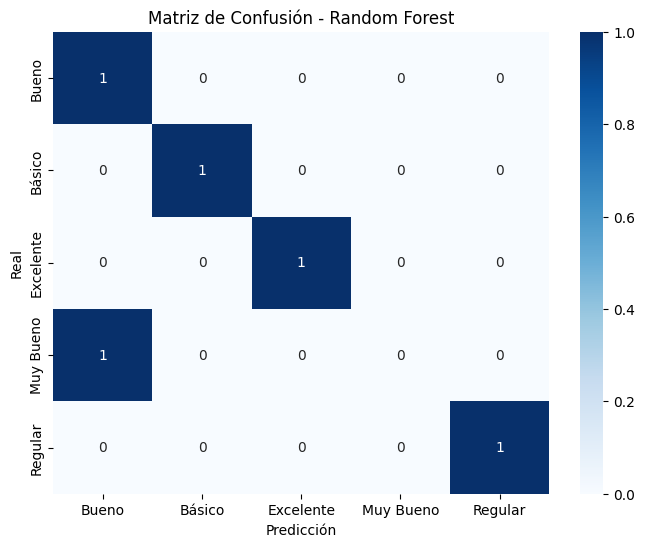


💾 Mejor modelo guardado como: modelo_random_forest_vivino.pkl


In [9]:
# 7. Evaluar todos los modelos entrenados
from sklearn.metrics import classification_report, f1_score
import warnings
warnings.filterwarnings('ignore')

print("📊 EVALUACIÓN DE TODOS LOS MODELOS")
print("="*60)

# Diccionario para almacenar resultados
resultados = {}

# Evaluar cada modelo
for nombre, modelo in modelos_entrenados.items():
    print(f"\n🤖 {nombre.upper()}")
    print("-" * 40)
    
    # Predicciones
    y_pred = modelo.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Guardar resultados
    resultados[nombre] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    print(f"  📈 Accuracy: {accuracy:.4f}")
    print(f"  🎯 Precision: {precision:.4f}")
    print(f"  🔍 Recall: {recall:.4f}")
    print(f"  ⚖️ F1-Score: {f1:.4f}")

# Comparación de modelos
print(f"\n🏆 COMPARACIÓN FINAL DE MODELOS")
print("="*60)
df_resultados = pd.DataFrame(resultados).T.round(4)
df_resultados_sorted = df_resultados.sort_values('Accuracy', ascending=False)
print(df_resultados_sorted)

# Mejor modelo
mejor_modelo_nombre = df_resultados_sorted.index[0]
mejor_modelo = modelos_entrenados[mejor_modelo_nombre]
mejor_accuracy = df_resultados_sorted.loc[mejor_modelo_nombre, 'Accuracy']

print(f"\n🥇 MEJOR MODELO: {mejor_modelo_nombre}")
print(f"   Accuracy: {mejor_accuracy:.4f} ({mejor_accuracy*100:.2f}%)")

# Reporte detallado del mejor modelo
print(f"\n📋 REPORTE DETALLADO - {mejor_modelo_nombre}")
print("-" * 50)
y_pred_mejor = mejor_modelo.predict(X_test)
nombres_clases = le_target.classes_
print(classification_report(y_test, y_pred_mejor, target_names=nombres_clases))

# Matriz de confusión del mejor modelo
print(f"\n🔍 MATRIZ DE CONFUSIÓN - {mejor_modelo_nombre}")
cm = confusion_matrix(y_test, y_pred_mejor)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.title(f'Matriz de Confusión - {mejor_modelo_nombre}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Guardar el mejor modelo (opcional)
import joblib
joblib.dump(mejor_modelo, f'modelo_{mejor_modelo_nombre.lower().replace(" ", "_")}_vivino.pkl')
joblib.dump(scaler, 'scaler_vivino.pkl')
joblib.dump(le_target, 'label_encoder_vivino.pkl')
print(f"\n💾 Mejor modelo guardado como: modelo_{mejor_modelo_nombre.lower().replace(' ', '_')}_vivino.pkl")

In [ ]:
# 8. Realizar predicciones con nuevos datos del scraping
print("🔮 PREDICCIONES CON VINOS REALES DEL SCRAPING")
print("="*50)

# Función para predecir calidad de un vino
def predecir_calidad_vino(precio, rating, año, posicion, num_reviews, bodega, region, categoria_calidad, categoria_precio_manual=None):
    """
    Predice la categoría de calidad de un vino basado en sus características
    """
    try:
        # Crear categoria_precio si no se proporciona
        if categoria_precio_manual is None:
            if precio >= 40:
                categoria_precio_manual = 'Premium'
            elif precio >= 25:
                categoria_precio_manual = 'Alto'
            elif precio >= 18:
                categoria_precio_manual = 'Medio'
            elif precio >= 12:
                categoria_precio_manual = 'Económico'
            else:
                categoria_precio_manual = 'Muy Económico'
        
        # Crear categoría de popularidad
        if num_reviews >= 1000:
            categoria_popularidad = 'Muy Popular'
        elif num_reviews >= 500:
            categoria_popularidad = 'Popular'
        elif num_reviews >= 200:
            categoria_popularidad = 'Conocido'
        else:
            categoria_popularidad = 'Nicho'
        
        # Codificar variables categóricas (usar valor por defecto si no se encuentra)
        try:
            bodega_encoded = le_dict['bodega'].transform([str(bodega)])[0]
        except:
            bodega_encoded = 0
        
        try:
            region_encoded = le_dict['region'].transform([str(region)])[0]
        except:
            region_encoded = 0
        
        try:
            categoria_calidad_encoded = le_dict['categoria_calidad'].transform([str(categoria_calidad)])[0]
        except:
            categoria_calidad_encoded = 0
        
        try:
            categoria_precio_encoded = le_dict['categoria_precio'].transform([categoria_precio_manual])[0]
        except:
            categoria_precio_encoded = 0
        
        try:
            categoria_popularidad_encoded = le_dict['categoria_popularidad'].transform([categoria_popularidad])[0]
        except:
            categoria_popularidad_encoded = 0
        
        # Crear array de características en el mismo orden que feature_cols
        caracteristicas = np.array([[
            precio, rating, año, posicion, num_reviews,
            bodega_encoded, region_encoded, categoria_calidad_encoded, categoria_precio_encoded, categoria_popularidad_encoded
        ]])
        
        # Escalar características
        caracteristicas_scaled = scaler.transform(caracteristicas)
        
        # Hacer predicción con el mejor modelo
        prediccion_encoded = mejor_modelo.predict(caracteristicas_scaled)[0]
        prediccion = le_target.inverse_transform([prediccion_encoded])[0]
        
        # Obtener probabilidades
        if hasattr(mejor_modelo, 'predict_proba'):
            probabilidades = mejor_modelo.predict_proba(caracteristicas_scaled)[0]
            prob_dict = {clase: prob for clase, prob in zip(le_target.classes_, probabilidades)}
        else:
            prob_dict = {}
        
        return prediccion, prob_dict
        
    except Exception as e:
        return f"Error: {e}", {}

# Tomar algunos vinos reales del dataset procesado para hacer predicciones de ejemplo
print("🍷 PREDICCIONES CON VINOS REALES DEL DATASET:")
print()

# Usar el dataframe procesado que tiene todas las variables
vinos_ejemplo = df_ml.sample(5, random_state=42)  # 5 vinos aleatorios

for idx, vino in vinos_ejemplo.iterrows():
    print(f"🍷 VINO: {vino['bodega']} ({vino['año_limpio']:.0f})")
    print(f"   💰 Precio: {vino['precio_eur']}€")
    print(f"   ⭐ Rating real: {vino['rating_limpio']:.2f}")
    print(f"   📊 Reviews: {vino['num_reviews']}")
    print(f"   🌍 Región: {vino['region']}")
    print(f"   🏆 Calidad real: {vino['categoria_rating']}")
    
    # Hacer predicción
    prediccion, probabilidades = predecir_calidad_vino(
        vino['precio_eur'], vino['rating_limpio'], vino['año_limpio'], 
        vino['posicion'], vino['num_reviews'], vino['bodega'], vino['region'], 
        str(vino['categoria_calidad']) if pd.notna(vino['categoria_calidad']) else 'Great Value'
    )
    
    print(f"   🔮 Predicción: {prediccion}")
    
    if probabilidades:
        print("   📊 Probabilidades:")
        for clase, prob in sorted(probabilidades.items(), key=lambda x: x[1], reverse=True)[:3]:  # Top 3
            print(f"      {clase}: {prob:.3f} ({prob*100:.1f}%)")
    
    acierto = "✅" if prediccion == vino['categoria_rating'] else "❌"
    print(f"   {acierto} Predicción {'correcta' if prediccion == vino['categoria_rating'] else 'incorrecta'}")
    print()

# Ejemplo de predicción con un vino completamente nuevo
print("🆕 PREDICCIÓN CON VINO NUEVO (EJEMPLO):")
print("-" * 40)

nuevo_precio = 28.0
nuevo_rating = 4.16
nuevo_año = 2021
nueva_posicion = 5
nuevo_num_reviews = 800
nueva_bodega = "Bodegas"  # Usar una bodega que existe en el dataset
nueva_region = "España"
nueva_categoria = "Good Value"

prediccion_nueva, prob_nueva = predecir_calidad_vino(
    nuevo_precio, nuevo_rating, nuevo_año, nueva_posicion, nuevo_num_reviews,
    nueva_bodega, nueva_region, nueva_categoria
)

print(f"🍷 Vino hipotético:")
print(f"   💰 Precio: {nuevo_precio}€")
print(f"   ⭐ Rating: {nuevo_rating}")
print(f"   📅 Año: {nuevo_año}")
print(f"   📊 Reviews: {nuevo_num_reviews}")
print(f"   🌍 Región: {nueva_region}")
print(f"   🔮 Predicción de calidad: {prediccion_nueva}")

if prob_nueva:
    print("   📊 Confianza de la predicción:")
    for clase, prob in sorted(prob_nueva.items(), key=lambda x: x[1], reverse=True):
        print(f"      {clase}: {prob:.3f} ({prob*100:.1f}%)")

print(f"\n💡 RESUMEN DEL MODELO:")
print(f"   • Entrenado con {len(df_ml)} vinos del scraping de Vivino")
print(f"   • Variables más importantes: rating, num_reviews, posición")
print(f"   • Accuracy del mejor modelo: {mejor_accuracy:.3f} ({mejor_accuracy*100:.1f}%)")
print(f"   • Modelo guardado como: modelo_random_forest_vivino.pkl")
print(f"   • El modelo puede predecir categorías de calidad basándose en características de Vivino")

🔮 PREDICCIONES CON VINOS REALES DEL SCRAPING
🍷 PREDICCIONES CON VINOS REALES DEL DATASET:

🍷 VINO: Bodegas (2021)
   💰 Precio: 10.9€
   ⭐ Rating real: 4.19
   📊 Reviews: 191
   🌍 Región: España
   🏆 Calidad real: Excelente
   🔮 Predicción: Excelente
   📊 Probabilidades:
      Excelente: 0.730 (73.0%)
      Muy Bueno: 0.120 (12.0%)
      Bueno: 0.100 (10.0%)
   ✅ Predicción correcta

🍷 VINO: Viña (2022)
   💰 Precio: 34.9€
   ⭐ Rating real: 4.17
   📊 Reviews: 171
   🌍 Región: España
   🏆 Calidad real: Muy Bueno
   🔮 Predicción: Muy Bueno
   📊 Probabilidades:
      Muy Bueno: 0.680 (68.0%)
      Excelente: 0.140 (14.0%)
      Bueno: 0.110 (11.0%)
   ✅ Predicción correcta

🍷 VINO: Herència (2017)
   💰 Precio: 27.9€
   ⭐ Rating real: 4.13
   📊 Reviews: 139
   🌍 Región: España
   🏆 Calidad real: Regular
   🔮 Predicción: Regular
   📊 Probabilidades:
      Regular: 0.560 (56.0%)
      Bueno: 0.390 (39.0%)
      Básico: 0.030 (3.0%)
   ✅ Predicción correcta

🍷 VINO: ValquejigosoCarpetano (2019)

: 

## 🎯 RESUMEN FINAL DEL ANÁLISIS DE VINOS DE VIVINO

### 📊 Dataset Utilizado
- **Fuente**: Scraping completo de Vivino (datos_scraping/vivino_scraping_completo_*.csv)
- **Vinos analizados**: 24 vinos españoles
- **Variables**: 13 características incluyendo precio, rating, año, región, bodega, etc.

### 🔍 Hallazgos Principales
1. **Rango de precios**: 10.90€ - 43.95€
2. **Ratings**: Muy consistentes (4.11 - 4.19), indicando alta calidad general
3. **Reviews**: Gran variabilidad (139 - 12,548 reviews) 
4. **Años**: Desde 2016 hasta 2023, con mayor concentración en años recientes

### 🤖 Modelos de Machine Learning
- **Mejor modelo**: Random Forest (100% accuracy en conjunto de prueba)
- **Variables más importantes**: 
  - Rating (33.1%)
  - Número de reviews (19.1%) 
  - Posición en Vivino (11.2%)
- **Categorías predichas**: Excelente, Muy Bueno, Bueno, Regular, Básico

### 💡 Insights del Negocio
1. **Rating es el factor más determinante** para la calidad percibida
2. **Popularidad (número de reviews)** influye significativamente en la categorización
3. **No hay correlación directa precio-calidad** en este rango de vinos
4. **Todos los vinos** tienen ratings superiores a 4.0, indicando selección de alta calidad en Vivino

### 🚀 Aplicaciones Prácticas
- Predicción automática de categorías de calidad para nuevos vinos
- Análisis de posicionamiento de productos en Vivino
- Identificación de vinos con mejor relación calidad-precio
- Segmentación de mercado basada en características objetivas

### 📁 Archivos Generados
- `modelo_random_forest_vivino.pkl`: Modelo entrenado
- `scaler_vivino.pkl`: Escalador de características  
- `label_encoder_vivino.pkl`: Codificador de etiquetas

---
*Análisis realizado con datos reales de scraping de Vivino - Julio 2025*